Parameters of the Largest Circle:
Center: (359, 172)
Radius: 35
Range of Sigma Values Used: 5.0 to 50.90000000000002


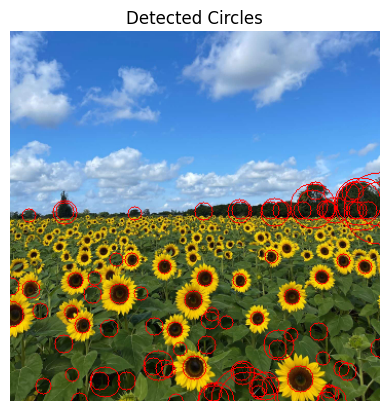

In [12]:
#Q1
import cv2 as cv
import numpy as np
from scipy.ndimage import maximum_filter
import matplotlib.pyplot as plt

#load image in reduced color
im = cv.imread('img.jpeg', cv.IMREAD_REDUCED_COLOR_4)
assert im is not None
gray_im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
#convert to grayscale

# Define a range of sigma values
sigma_values = np.arange(5, 51, 0.9)

# Initialize an array to store the scale space
scale_space = []

for sigma in sigma_values:
    # Calculate the LoG kernel for the current sigma 
    kernel_hw = (int(4 * sigma) + 1) // 2
    X, Y = np.meshgrid(np.arange(-kernel_hw, kernel_hw + 1), np.arange(-kernel_hw, kernel_hw + 1))
    LoG = (X ** 2 + Y ** 2 - 2 * sigma ** 2) * np.exp(-(X ** 2 + Y ** 2) / (2 * sigma ** 2))

    # LoG filtering to the grayscale image
    response = cv.filter2D(gray_im.astype(np.float32), -1, LoG)

    # Store the result in the scale space
    scale_space.append(response)

# Convert the scale space to a numpy array
scale_space = np.array(scale_space)

# Find local maxima in the scale space using a maximum filter
local_maxima = maximum_filter(scale_space, size=(3, 3, 3))

# Identify the coordinates of the local maxima
maxima_coordinates = np.argwhere((scale_space == local_maxima) & (local_maxima > 0))

circles_detected = []

for coordinates in maxima_coordinates:
    z, y, x = coordinates
    # Adjust the scale factor to maximize strength
    radius = int(np.sqrt(2) * sigma_values[z])  
    center = (x, y)
    circles_detected.append((center, radius))

largest_circle = max(circles_detected, key=lambda x: x[1])
largest_center, largest_radius = largest_circle
print("Parameters of the Largest Circle:")
print("Center:", largest_center)
print("Radius:", largest_radius)
print("Range of Sigma Values Used:", sigma_values[0], "to", sigma_values[-1])

# Draw detected circles on the original image
output_image = im.copy()
for circle in circles_detected:
    center, radius = circle
    cv.circle(output_image, center, radius, (0, 0, 255), 1)  # Draw circles in red

# Convert BGR image to RGB for Matplotlib
output_image_rgb = cv.cvtColor(output_image, cv.COLOR_BGR2RGB)

# Display the image with detected circles using Matplotlib

plt.imshow(output_image_rgb)
plt.title("Detected Circles")
plt.axis('off')
plt.show()





.....................................RANSAC LINE FITTING............................................
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.453749504626578e-07
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
Iteration 1:
Estimated Model Parameters (a, b, d): [0.71139712 0.7027906  3.36121899]
Number of Inliers: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.1489229869386496e-09
            Iterations: 5
            Function evaluations: 23
            Gradient evaluations: 5
Iteration 2:
Estimated Model Parameters (a, b, d): [ 0.77001206  0.63803008 -0.03553855]
Number of Inliers: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.9585426308116047e-07
            Iterations: 5
            Function evaluations: 24
            Gradient evaluations: 5
Iteration 3:
Estimated Model Parameters (a, 

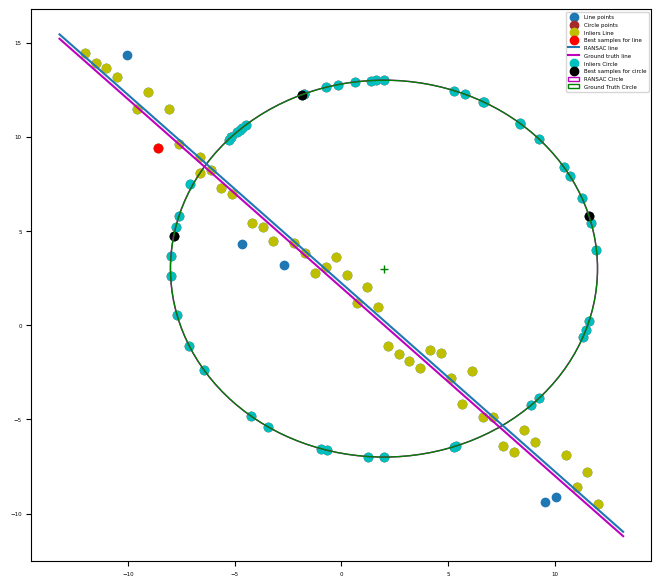

In [32]:
from scipy.optimize import minimize
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
#import tikzplotlib


N=100 #number of points
half_n=N//2 #number of points allocated to each class
#circle parameters
r=10 #radius
x0_gt,y0_gt = 2,3 #center
s =r/16 #standard deviation
t=np.random.uniform(0,2*np.pi,half_n) #angle
n = np.random.randn(half_n) #noise
x,y=x0_gt+r*np.cos(t),y0_gt+r*np.sin(t) #points on circle x^2+y^2=r^2 parametric form
X_circ = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1))) #circle points; 2 column arrays horizzontal concatanation
s=1
#line parameters
m,b=-1,2 #slope and intercept
x=np.linspace(-12,12,half_n) #points on line x axis
y= m*x+b+s*np.random.randn(half_n) #points on line y=mx+b
X_line = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1))) #line points
X=np.vstack((X_circ,X_line)) #all points on line and circle vertically concatanated



#(a)........................................RANSAC LINE FITTING.............................................

N = X.shape[0]  # Number of points
X = X  # Data matrix

print("\n.....................................RANSAC LINE FITTING............................................")
l_threshold = 1.   # Threshold value to determine data points that are fit well by model.
l_max_iterations = 100
l_data_points = 0.4*N   # Number of close data points required to assert that a model fits well to data.
l_estimate_data_points = 2       # Minimum number of data points required to estimate model parameters.
l_best_error = np.inf

l_inliers_line = []        # Indinces of the inliers
l_best_model_line = []     # Best model normal (a, b) and distance from origin d
l_best_sample_line = []    # Three-point sample leading to the best model computation
l_res_only_with_sample = [] # Result (a, b, d) only using the best sample
l_best_inliers_line = []   # Inliers of the model computed form the best sample


# RANSAC to fit a line
#function to create random sample of 2 points from the datalist X_
def sample_points(X,n):
    indices = np.random.randint(0, N, n) #randomly selecting n indices from 0 to N
    return X[indices,:] #returning n points from X_ with the selected indices

# hypothesize a model function to fit a line to the sample points; RANSAC to fit a line
def line_model(x, indices):
    a,b,d = x[0],x[1],x[2] #model parameters
    return np.sum(np.square(a*X[indices,0] + b*X[indices,1] - d)) #sum of squared distances of all points from the line
    
def line_constraint(x):
    # Extract the model parameters
    a, b = x[0], x[1]
    # Apply the constraint ∥[a, b]⊺∥ = 1
    return np.linalg.norm([a, b]) - 1

cons = ({'type': 'eq', 'fun': line_constraint}) #constraint on the model parameters

#compute error function

# Set of inliers (consensus)
def consensus_line(X, x, l_threshold):
    a, b, d = x[0], x[1], x[2] #line model parameters
    error = np.absolute(a*X[:,0] + b*X[:,1] - d) #absolute distance of all points from the line
    return error < l_threshold #returning indices of points with distance less than threshold


l_iteration = 0
while l_iteration < l_max_iterations:   
    # Randomly select 2 data points for the sample
    indices = np.random.randint(0, N, l_estimate_data_points)
    x0 = np.array([1, 1, 0])  # Initial estimate
    res = minimize(fun=line_model, args=indices, x0=x0, tol=1e-6, constraints=cons, options={'disp': True})

    # Compute inliers based on the optimized model
    l_inliers_line = consensus_line(X, res.x, l_threshold)

    # Print iteration details
    print(f'Iteration {l_iteration + 1}:')
    print(f'Estimated Model Parameters (a, b, d): {res.x}')
    print(f'Number of Inliers: {l_inliers_line.sum()}')

    if l_inliers_line.sum() > l_data_points:
        x0 = res.x 
        # Refine the model using inliers
        res = minimize(fun=line_model, args=l_inliers_line, x0=x0, tol=1e-6, constraints=cons, options={'disp': True})

        if res.fun < l_best_error:
            print(f'A better model found: (a, b, d) = {res.x}, Error = {res.fun}')
            l_best_model_line = res.x
            best_error = res.fun
            l_best_sample_line = sample_points(X, l_estimate_data_points)
            l_res_only_with_sample = x0
            l_best_inliers_line = l_inliers_line

    l_iteration += 1

print('\nBest Line Model:')
print(f'(a, b, d) = {l_best_model_line}')
print(f'Error = {best_error}')

print('Best line model', l_best_model_line)


#(b)........................................RANSAC CIRCLE FITTING.............................................
print('\n')
print('no of elements in X',len(X))
print('no of inliers',np.sum(l_best_inliers_line))


print("\n.....................................RANSAC CIRCLE FITTING............................................")

c_threshold = 1.
c_max_iterations = 100
c_data_points = 35   # Number of close data points required to assert that a model fits well to data.
c_estimate_data_points = 3       # Minimum number of data points required to estimate model parameters.
c_best_error = np.inf

c_inliers =[]
c_best_model = []
c_best_inliers = []
c_best_sample= []
c_res_only_with_sample = []

#(b)Subtracting the inliers of the line from the data points to get the points on the circle
line_outliers = np.where(l_best_inliers_line==False)[0]
remnants = np.array([X[line_outliers[i]] for i in range(len(line_outliers))])
print('remnants',len(remnants))

#function to create random sample of 3 points on corcle from the datalist remenants
    
def sample_points_circle(N1,n):
    c_indices = np.random.randint(0, N1, n) #randomly selecting n indices from 0 to N
    return c_indices #returning n points from X_ with the selected indices

# hypothesize a model function to fit a circle to the sample points; RANSAC to fit a circle
def circle_model(x, indices):
    x0, y0, r = x
    x1, y1 = remnants[indices].T
    return np.sum((np.sqrt((x1 - x0)**2 + (y1 - y0)**2) - r)**2)

# Constraints 
def g(x): 
    return x[0]**2 + x[1]**2 - 1 

cons1 = ({'type': 'eq', 'fun': g})


'''If g(x) equals 0, it means the point x lies exactly on the circle's boundary.
If g(x) is less than 0, it means the point x is inside the circle.
If g(x) is greater than 0, it means the point x is outside the circle.'''

# Set of inliers (consensus)
def consenus_circle(remnants, x, c_threshold):
    distances = np.abs(np.linalg.norm(remnants - x[:2], axis=1) - x[2])
    # Count number of inliers
    return distances < c_threshold

c_iteration = 0
while c_iteration < c_max_iterations:
    c_indices = np.random.randint(0,len(remnants), c_estimate_data_points)
    x0 = np.array([0,0,0]) #initial guess
    res = minimize(circle_model, x0, args=c_indices, tol=1e-6) #minimize the error
    c_inliers = consenus_circle(remnants, res.x, c_threshold)  #find the consensus set

    # Print iteration details
    print(f'Iteration {c_iteration + 1}:')
    print(f'Estimated Model Parameters (x0, y0, r): {res.x}')
    print(f'Number of Inliers: {np.sum(c_inliers)}')
    if np.sum(c_inliers) > c_data_points:
            x0 = res.x
            res = minimize(circle_model, x0=x0, args=(c_inliers),tol= 1e-6)
            if res.fun < c_best_error:
                print(f'A better model found: (x0, y0, r) = {res.x}, Error = {res.fun}')
                c_best_error = res.fun
                c_best_sample= sample_points_circle(len(remnants), c_estimate_data_points)
                c_best_model = res.x
                c_res_only_with_sample = x0
                c_best_inliers = c_inliers

    c_iteration += 1


print('\nBest Circle Model:')
print(f'(x0, y0, r) = {c_best_model}')
print(f'Error = {c_best_error}')




fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0],X_line[:,1], label='Line points')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle points', color='brown')
ax.scatter(X[l_best_inliers_line,0],X[l_best_inliers_line,1], color='y', label='Inliers Line')
ax.scatter(l_best_sample_line[:,0],l_best_sample_line[:,1], color='r', label='Best samples for line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-l_best_model_line[1]*x_ + l_best_model_line[2])/l_best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

ax.scatter(remnants[c_best_inliers,0],remnants[c_best_inliers,1],color='c',label='Inliers Circle')
ax.scatter(remnants[c_best_sample,0],remnants[c_best_sample,1],color='k',label='Best samples for circle')
circle = plt.Circle((c_best_model[0], c_best_model[1]), c_best_model[2], color='m', fill=False, label='RANSAC Circle')
ax.add_patch(circle)
circle_gt=plt.Circle((x0_gt,y0_gt),r,color='g',fill=False,label='Ground Truth Circle') #plotting ground truth circle in green
ax.add_patch(circle_gt) #adding ground truth circle to plot
ax.plot((x0_gt),(y0_gt),'+',color='g') #plotting centre of ground truth circle

plt.legend()


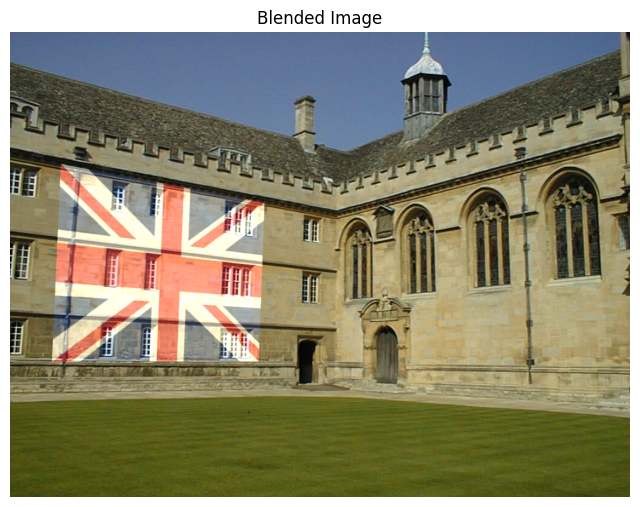

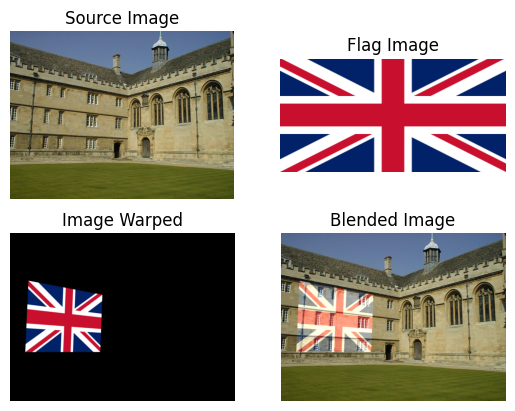

In [14]:
#Q3
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Constants
NUM_POINTS = 4

# Global variable
global point_index
point_index = 0


# Initialize arrays to store mouse points
base_points = np.empty((NUM_POINTS, 2))
flag_points = np.empty((NUM_POINTS, 2))

# Callback function for mouse events
def record_mouse_points(event, x, y, flags, param):
    global point_index
    points, image = param
    if event == cv.EVENT_LBUTTONDOWN and point_index < NUM_POINTS:
        cv.circle(image, (x, y), 5, (255, 0, 0), -1)
        points[point_index] = (x, y)
        point_index += 1

# Load images and create copies
base_image = cv.imread('Images for Q3/Bunglow.jpg', cv.IMREAD_COLOR)
flag_image = cv.imread('Images for Q3/UK_flag.png', cv.IMREAD_COLOR)
base_image_copy = base_image.copy()
flag_image_copy = flag_image.copy()


# Create windows and set mouse callbacks
cv.namedWindow('Base Image', cv.WINDOW_AUTOSIZE)

cv.setMouseCallback('Base Image', record_mouse_points, (base_points, base_image_copy))

# Collect mouse points for the base image
while True:
    cv.imshow('Base Image', base_image_copy)
    if point_index == NUM_POINTS:
        break
    key = cv.waitKey(20)
    if key & 0xFF == 27:
        break

# Reset point_index for collecting mouse points for the flag image
point_index = 0    
cv.namedWindow('Flag Image', cv.WINDOW_AUTOSIZE)

cv.setMouseCallback('Flag Image', record_mouse_points, (flag_points, flag_image_copy))




# Collect mouse points for the flag image
while True:
    cv.imshow('Flag Image', flag_image_copy)
    if point_index == NUM_POINTS:
        break
    key = cv.waitKey(20)
    if key & 0xFF == 27:
        break

cv.destroyAllWindows()

# Calculate homography between base image and flag
homography, status = cv.findHomography(base_points, flag_points)

# Warp the flag image
warped_flag = cv.warpPerspective(flag_image, np.linalg.inv(homography), (base_image.shape[1], base_image.shape[0]))

# Blending
alpha = 1
beta = 0.5
blended_image = cv.addWeighted(base_image, alpha, warped_flag, beta, 0.0)

# Display the blended image
plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
plt.title("Blended Image")
plt.axis("off")

# Display the results in a 2x2 grid

fig, ax = plt.subplots(2, 2)
ax[0][0].imshow(cv.cvtColor(base_image, cv.COLOR_BGR2RGB))
ax[0][0].set_title("Source Image")
ax[0][0].axis("off")


ax[0][1].imshow(cv.cvtColor(flag_image, cv.COLOR_BGR2RGB))
ax[0][1].set_title("Flag Image")
ax[0][1].axis("off")

ax[1][0].imshow(cv.cvtColor(warped_flag, cv.COLOR_BGR2RGB))
ax[1][0].set_title("Image Warped")
ax[1][0].axis("off")

ax[1][1].imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
ax[1][1].set_title("Blended Image")
ax[1][1].axis("off")



plt.show()


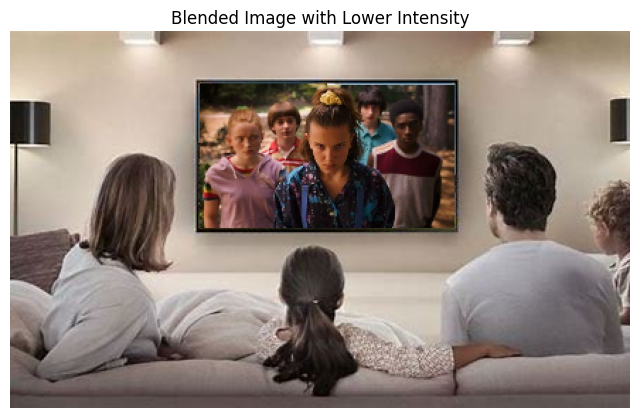

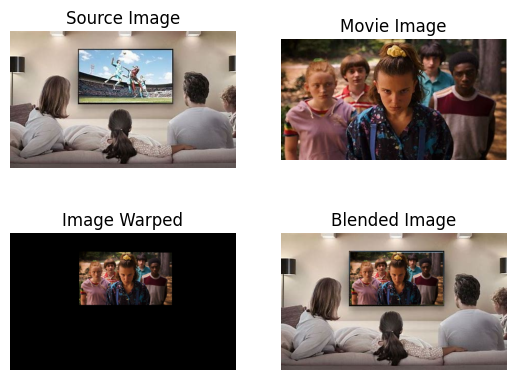

In [15]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Constants
NUM_POINTS = 4

# Global variable
global point_index
point_index = 0

# Initialize arrays to store mouse points
base_points = np.empty((NUM_POINTS, 2))
movie_points = np.empty((NUM_POINTS, 2))

# Callback function for mouse events
def record_mouse_points(event, x, y, flags, param):
    global point_index
    points, image = param
    if event == cv.EVENT_LBUTTONDOWN and point_index < NUM_POINTS:
        cv.circle(image, (x, y), 5, (255, 0, 0), -1)
        points[point_index] = (x, y)
        point_index += 1

# Load images and create copies
base_image = cv.imread('Images for Q3/TV look.jpeg', cv.IMREAD_COLOR)
movie_image = cv.imread('Images for Q3/TV.jpeg', cv.IMREAD_COLOR)
base_image_copy = base_image.copy()
movie_image_copy = movie_image.copy()

# Create windows and set mouse callbacks
cv.namedWindow('Base Image', cv.WINDOW_AUTOSIZE)
cv.setMouseCallback('Base Image', record_mouse_points, (base_points, base_image_copy))

# Collect mouse points for the base image
while True:
    cv.imshow('Base Image', base_image_copy)
    if point_index == NUM_POINTS:
        break
    key = cv.waitKey(20)
    if key & 0xFF == 27:
        break

# Reset point_index for collecting mouse points for the movie image
point_index = 0
cv.namedWindow('Movie Image', cv.WINDOW_AUTOSIZE)
cv.setMouseCallback('Movie Image', record_mouse_points, (movie_points, movie_image_copy))

# Collect mouse points for the movie image
while True:
    cv.imshow('Movie Image', movie_image_copy)
    if point_index == NUM_POINTS:
        break
    key = cv.waitKey(20)
    if key & 0xFF == 27:
        break

cv.destroyAllWindows()

# Calculate homography between base image and movie
homography, status = cv.findHomography(base_points, movie_points)

# Warp the movie image
warped_movie = cv.warpPerspective(movie_image, np.linalg.inv(homography), (base_image.shape[1], base_image.shape[0]))

# Create a mask for the selected region
mask = np.zeros_like(base_image)
cv.fillConvexPoly(mask, base_points.astype(int), (1, 1, 1))  # Fill the selected region with white (1, 1, 1)

# Define a lower intensity for the selected region
lower_intensity = 1  # Adjust this value as needed

# Adjust the intensity of the selected region in the blended image
blended_image = base_image * (1 - mask) + (warped_movie * mask * lower_intensity).astype(np.uint8)

# Display the blended image
plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
plt.title("Blended Image with Lower Intensity")
plt.axis("off")

# Display the results
fig, ax = plt.subplots(2, 2)
ax[0][0].imshow(cv.cvtColor(base_image, cv.COLOR_BGR2RGB))
ax[0][0].set_title("Source Image")
ax[0][0].axis("off")

ax[0][1].imshow(cv.cvtColor(movie_image, cv.COLOR_BGR2RGB))
ax[0][1].set_title("Movie Image")
ax[0][1].axis("off")

ax[1][0].imshow(cv.cvtColor(warped_movie, cv.COLOR_BGR2RGB))
ax[1][0].set_title("Image Warped")
ax[1][0].axis("off")

ax[1][1].imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
ax[1][1].set_title("Blended Image")
ax[1][1].axis("off")

plt.show()


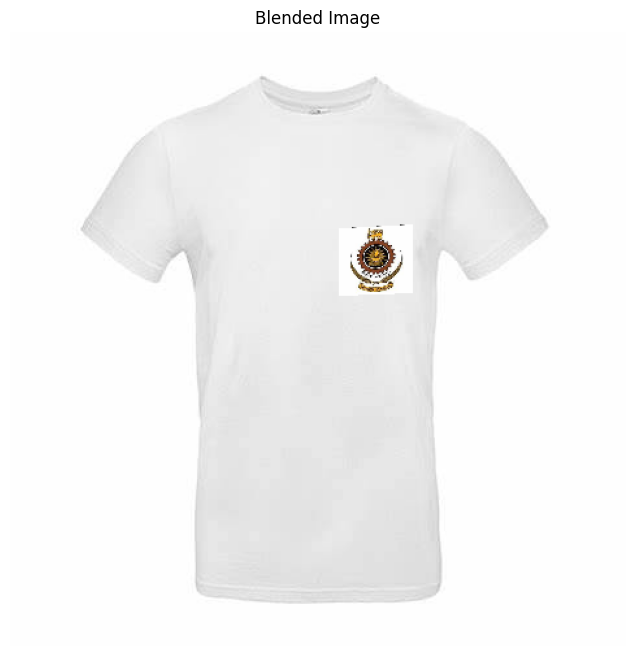

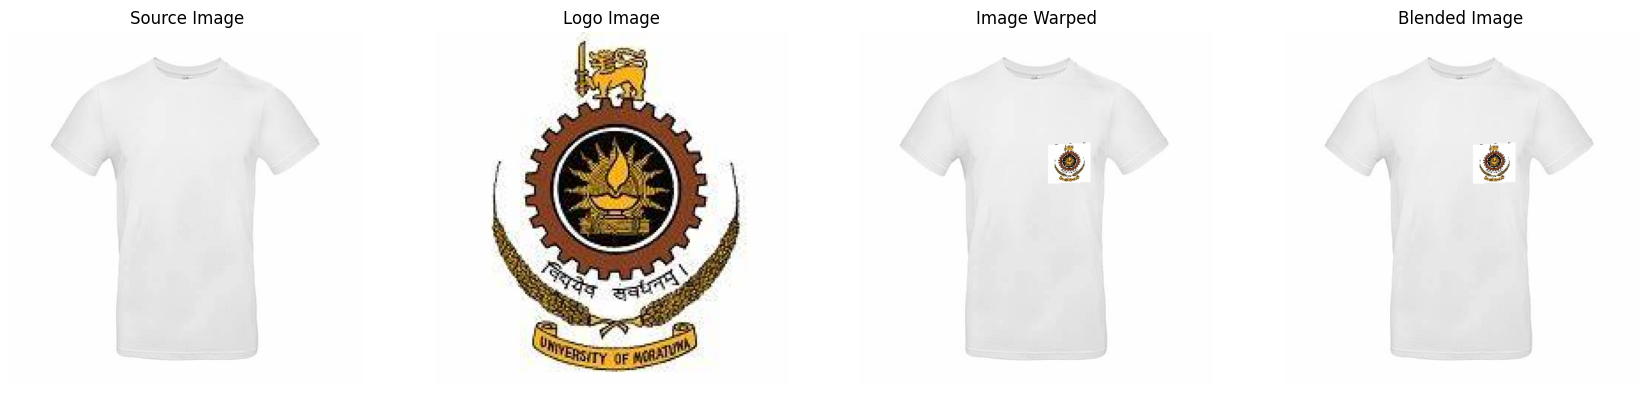

In [16]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Constants
NUM_POINTS = 4

# Global variable
global point_index
point_index = 0

# Initialize arrays to store mouse points
base_points = np.empty((NUM_POINTS, 2))
logo_points = np.empty((NUM_POINTS, 2))

# Callback function for mouse events
def record_mouse_points(event, x, y, flags, param):
    global point_index
    points, image = param
    if event == cv.EVENT_LBUTTONDOWN and point_index < NUM_POINTS:
        cv.circle(image, (x, y), 5, (255, 0, 0), -1)
        points[point_index] = (x, y)
        point_index += 1

# Load images and create copies
base_image = cv.imread('Images for Q3/Tshirt.jpeg', cv.IMREAD_COLOR)
logo_image = cv.imread('Images for Q3/Logo.jpeg', cv.IMREAD_COLOR)
base_image_copy = base_image.copy()
logo_image_copy = logo_image.copy()

# Create windows and set mouse callbacks
cv.namedWindow('Base Image', cv.WINDOW_AUTOSIZE)
cv.setMouseCallback('Base Image', record_mouse_points, (base_points, base_image_copy))

# Collect mouse points for the base image
while True:
    cv.imshow('Base Image', base_image_copy)
    if point_index == NUM_POINTS:
        break
    key = cv.waitKey(20)
    if key & 0xFF == 27:
        break

# Reset point_index for collecting mouse points for the logo image
point_index = 0
cv.namedWindow('Logo Image', cv.WINDOW_AUTOSIZE)
cv.setMouseCallback('Logo Image', record_mouse_points, (logo_points, logo_image_copy))

# Collect mouse points for the logo image
while True:
    cv.imshow('Logo Image', logo_image_copy)
    if point_index == NUM_POINTS:
        break
    key = cv.waitKey(20)
    if key & 0xFF == 27:
        break

cv.destroyAllWindows()

# Calculate homography between base image and logo
homography, status = cv.findHomography(base_points, logo_points)

# Warp the logo image
warped_logo = cv.warpPerspective(logo_image, np.linalg.inv(homography), (base_image.shape[1], base_image.shape[0]))

# Create a mask for the selected region
mask = np.zeros_like(base_image)
cv.fillConvexPoly(mask, base_points.astype(int), (1, 1, 1))  # Fill the selected region with white (1, 1, 1)

# Define a lower intensity for the selected region
lower_intensity = 1  # Adjust this value as needed

# Adjust the intensity of the selected region in the blended image
blended_image = base_image * (1 - mask) + (warped_logo * mask * lower_intensity).astype(np.uint8)

# Display the blended image
plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
plt.title("Blended Image")
plt.axis("off")

# Display the results
fig, ax = plt.subplots(1, 4, figsize=(21, 7))
ax[0].imshow(cv.cvtColor(base_image, cv.COLOR_BGR2RGB))
ax[0].set_title("Source Image")
ax[0].axis("off")
ax[1].imshow(cv.cvtColor(logo_image, cv.COLOR_BGR2RGB))
ax[1].set_title("Logo Image")
ax[1].axis("off")
ax[2].imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
ax[2].set_title("Image Warped")
ax[2].axis("off")
ax[3].imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
ax[3].set_title("Blended Image")
ax[3].axis("off")


plt.show()


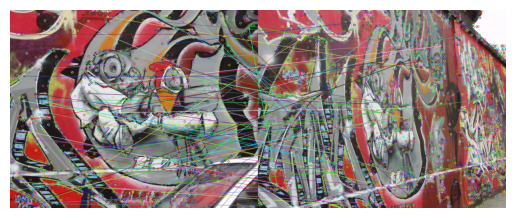

In [17]:
#Q4 a)

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load images
image1 = cv.imread('Images for Q4/img1.ppm')  
image5 = cv.imread('Images for Q4/img5.ppm')


# Initialize SIFT detector
sift = cv.SIFT_create()

# Detect SIFT features and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints5, descriptors5 = sift.detectAndCompute(image5, None)

# Create a BFMatcher (Brute-Force Matcher)
bf_matcher = cv.BFMatcher()

# Match SIFT features between the two images
matches = bf_matcher.knnMatch(descriptors1, descriptors5, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
for match1, match2 in matches:
    if match1.distance < 0.75 * match2.distance:
        good_matches.append(match1)

# Extract locations of good matches
points_image1 = np.zeros((len(good_matches), 2), dtype=np.float32)
points_image5 = np.zeros((len(good_matches), 2), dtype=np.float32)
for i, match in enumerate(good_matches):
    points_image1[i, :] = keypoints1[match.queryIdx].pt
    points_image5[i, :] = keypoints5[match.trainIdx].pt

# Draw and display the matching
matched_image = cv.drawMatches(image1, keypoints1, image5, keypoints5, good_matches, None)
plt.imshow(cv.cvtColor(matched_image, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()




In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def Hormo_cal(arr):
    A = []
    for i in range(len(arr)):
        x1, y1, x2, y2 = arr[i, 0], arr[i, 1], arr[i, 2], arr[i, 3]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])

    A = np.matrix(A)
    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3))
    H = (1/H.item(8))*H
    return H

def Distanse_cal(H, correspondence):
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(H, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


def RANSAC(corres,threshold):
    max_inliers = []
    homography = []

    #(int(np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**4)))

    for i in range(100):
        corr1 = corres[np.random.randint(0, len(corres))]
        corr2 = corres[np.random.randint(0, len(corres))]
        arr = np.vstack((corr1, corr2))
        corr3 = corres[np.random.randint(0, len(corres))]
        arr = np.vstack((arr, corr3))
        corr4 = corres[np.random.randint(0, len(corres))]
        arr = np.vstack((arr, corr4))
        
        
        h = Hormo_cal(arr)
        inliers = np.zeros((1,4))
        
        for j in range(len(corres)):
            distance = Distanse_cal(h, corres[j])
            if distance < 5:
                inliers = np.vstack((inliers,corres[j]))
               
        inliers = np.delete(inliers,0,0)

        if len(inliers) > threshold:
            max_inliers = inliers
            homography = Hormo_cal(max_inliers)
       
    return homography,max_inliers

img_lst = []
for i in range(1,6):
    img = cv.imread('Images for Q4/img'+str(i)+'.ppm')
    img_lst.append(img)


homo = []
estimated_threshold = 100
sift = cv.SIFT_create()
bf = cv.BFMatcher()

for i in range(4):
    correspondence = []
    keypoint1, desig1 = sift.detectAndCompute(img_lst[i],None)
    keypoint2, desig2 = sift.detectAndCompute(img_lst[i+1],None)
    matching_points = bf.knnMatch(desig1, desig2, k=2)
    keypoints = [keypoint1, keypoint2]

    for match in matching_points:
        (x1, y1) = keypoints[0][match[0].queryIdx].pt
        (x2, y2) = keypoints[1][match[0].trainIdx].pt
        correspondence.append([x1, y1, x2, y2])

    corres = np.matrix(correspondence)
    H,inliers =RANSAC(corres,estimated_threshold)
    homo.append(H)

final = homo[3]@homo[2]@homo[1]@homo[0]
H = (1/final.item(8))*final
print('Homography calculated \n',H)

Homography calculated 
 [[ 6.64296360e-01  4.73244744e-01  1.54623745e+02]
 [ 1.47096840e-01  1.90988661e+00 -1.76854317e+02]
 [ 3.17252032e-04  8.18685683e-04  1.00000000e+00]]


(-0.5, 799.5, 639.5, -0.5)

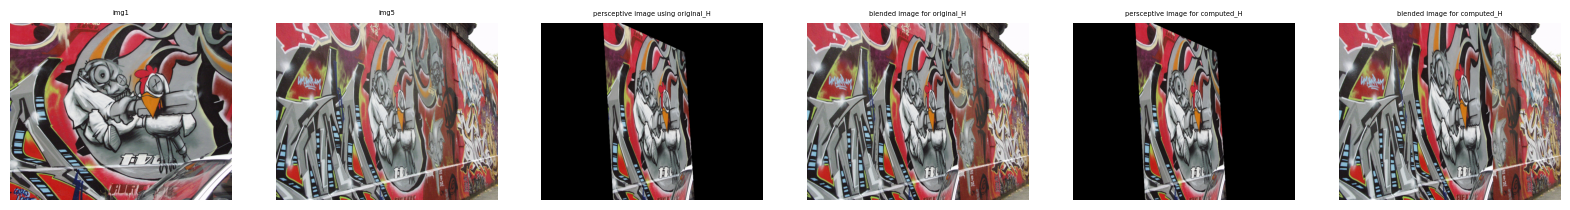

In [13]:
import cv2  as cv
import numpy as np
import matplotlib.pyplot as plt
#use small font for tiltle in plots
plt.rcParams.update({'font.size': 4})
#increase image gaps in plots
plt.rcParams['figure.subplot.hspace'] = 0.6
#decrease gap between image and title of each iamge in plots
plt.rcParams['figure.subplot.top'] = 0.8
#increase image sizes
plt.rcParams['figure.figsize'] = [20, 20]


plt.subplot(1,6,1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('img1')
plt.axis('off')

plt.subplot(1,6,2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('img5')
plt.axis('off')


h_text = open('Images for Q4/H1to5p','r')



#coverting h_text to homography matrix
original_H = []
for line in h_text:
    line = line.strip()
    line = line.split()
    line = [float(i) for i in line]
    original_H.append(line)

#using final homography matrix
computed_H = []
for i in range(3):
    computed_H.append(H[i].tolist()[0])

# Convert computed_H to the appropriate data type and size
#computed_H = computed_H.astype(np.float32)



#converting to matrix
computed_H = np.matrix(computed_H)

original_H = np.matrix(original_H)

image_perspective = cv.warpPerspective(img1, original_H, (img5.shape[1], img5.shape[0]))
plt.subplot(1,6,3)
plt.imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
plt.title('persceptive image using original_H')
plt.axis('off')

#blending
threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)
output_image = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
#difference = cv.circle(output_image, (500, 600), 100, (0, 0, 255), 5)

#dst = cv.add(image_perspective, img5_bg)
plt.subplot(1,6,4)
plt.imshow(output_image) 
plt.title('blended image for original_H')
plt.axis('off')

# Warp the image using the computed_H matrix
image_perspective1 = cv.warpPerspective(img1, computed_H, (img5.shape[1], img5.shape[0]))

#image_perspective1 = cv.warpPerspective(image1, computed_H, (image5.shape[1], image5.shape[0]))
plt.subplot(1,6,5)
plt.imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
plt.title('persceptive image for computed_H')
plt.axis('off')

#blending
threshold, mask = cv.threshold(cv.cvtColor(image_perspective1, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)
output_image = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
#difference = cv.circle(output_image, (500, 600), 100, (0, 0, 255), 5)

threshold, mask = cv.threshold(cv.cvtColor(image_perspective1, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective1, 1, 0)
output_image = cv.cvtColor(dst, cv.COLOR_BGR2RGB)

#dst = cv.add(image_perspective, img5_bg)
plt.subplot(1,6,6)
plt.imshow(output_image) 
plt.title('blended image for computed_H')
plt.axis('off')


